In [56]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import torchvision
from torchvision import transforms as T

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from modeldiff import ModelDiff
from src.data.datasets import Living17
from src.utils import plot_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup data

In [17]:
_metadata = pd.read_pickle('metadata/living17_val_metadata.df')
class_names = dict(zip(_metadata['class'], _metadata['class_name'].apply(lambda s: s[:10])))

IMAGENET_DIR = '/mnt/cfs/datasets/pytorch_imagenet' 
living17_tf = T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dsets = {
    'val': Living17('val', living17_tf, imagenet_dir=IMAGENET_DIR),
    'train': Living17('train', living17_tf, imagenet_dir=IMAGENET_DIR)
}

labels = {
    'val': [[x] for x in pd.read_pickle('metadata/living17_val_metadata.df')['class'].tolist()],
    'train': [[x] for x in pd.read_pickle('metadata/living17_train_metadata.df')['class'].tolist()]
}

### Helper functions

In [3]:
# helper function to convert mmap into state dict
def from_npy_to_state_dict(ndarr, model):
    def vector_to_parameters(vec, parameters) -> None:
        pointer = 0
        for param in parameters:
            num_param = param.numel()
            param.data = vec[pointer:pointer + num_param].view_as(param).data
            pointer += num_param

    ndarr = torch.from_numpy(ndarr).cuda()
    PARAM_LEN = 11185233
    sd_list = []

    for v in ndarr:
        params = v[:PARAM_LEN].float()
        buffs = v[PARAM_LEN:].float()
        vector_to_parameters(torch.tensor(params), model.parameters())
        vector_to_parameters(torch.tensor(buffs), model.buffers())
        model.eval()
        sd_list.append(model.state_dict().copy())

    return sd_list

### Initialize the models we want to compare.
For simplicity, we use the same architecture for both models; note that though this is not necessary. 

In [4]:
# define architecture for algorithm A and B
modelA = torchvision.models.resnet18()
modelA.fc = torch.nn.Linear(512, 17)
modelA.eval()
modelA.cuda() 

modelB = torchvision.models.resnet18()
modelB.fc = torch.nn.Linear(512, 17)
modelB.eval()
modelB.cuda();

### Initialize training and validation dataloaders

Has to be the same for both models.

In [5]:
batch_size = 256
num_workers = 4
train_loader = DataLoader(dataset=dsets['train'], batch_size=batch_size, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(dataset=dsets['val'], batch_size=batch_size, num_workers=num_workers, pin_memory=True)

### Load checkpoints
Load multiple model checkpoints in order to compute TRAK attribution scores. For more details, check out TRAK's [repo](https://github.com/MadryLab/trak) (and TRAK's [quickstart](https://trak.readthedocs.io/en/latest/quickstart.html)).

The expected format is a list of `state_dict`s

In [6]:
# note: run scripts/download_living17_checkpoints.sh first
# take the ckpts of the first K models trained with alg A and alg B
num_models = 30
all_ckpts = torch.load(Path('../checkpoints/living17.pt'))
ckptsA = from_npy_to_state_dict(all_ckpts['with data aug'], modelA)[:num_models] 
ckptsB = from_npy_to_state_dict(all_ckpts['without data aug'], modelB)[:num_models]

/tmp/ipykernel_1064664/2390731415.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vector_to_parameters(torch.tensor(params), model.parameters())
/tmp/ipykernel_1064664/2390731415.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vector_to_parameters(torch.tensor(buffs), model.buffers())


### Initialize the `ModelDiff` instance

In [7]:
md = ModelDiff(modelA, modelB, ckptsA, ckptsB, train_loader=train_loader)

                             Report any issues at https://github.com/MadryLab/trak/issues
INFO:STORE:Existing model IDs in /mnt/cfs/home/harshay/repos/modeldiff/notebooks/modeldiff_scores/modelA: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
INFO:STORE:Model IDs that have been finalized: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Existing TRAK scores:
INFO:STORE:exp: /mnt/cfs/home/harshay/repos/modeldiff/notebooks/modeldiff_scores/modelA/scores/exp.mmap
                             Report any issues at https://github.com/MadryLab/trak/issues
INFO:STORE:Existing model IDs in /mnt/cfs/home/harshay/repos/modeldiff/notebooks/modeldiff_scores/modelB: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Model IDs that have been finalized: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
INFO:STORE:Existing TRAK scores:
INFO:STORE:exp: /mnt/cfs/home/harshay/repos/modeldiff/notebooks/modeldiff_scores/modelB/scores/exp.mmap


Once we've initialized the `md` instance, we can use it to compute `diff`s wrt many different target datasets (e.g., like with `val_loader`).

### Run any `diff` of choice!

Now you can compute `A-B` and `B-A` to get `diff_ab` and `diff_ba` are dictionaries of the form:
```python
{
    'directions': ...,
    'projections': ...,
    'variances': ...,
    'scores': {'A': ..., 'B': ...}
}
```

In [ ]:
num_pc_directions = 50
diff1 = md.get_A_minus_B(val_loader=val_loader, num_pca_comps=num_pc_directions)
diff2 = md.get_B_minus_A(val_loader=val_loader, num_pca_comps=num_pc_directions)

torch.save(diff1, '/tmp/diff_ab.pt')
torch.save(diff2, '/tmp/diff_ba.pt')

`diff_ab` and `diff_ba` are dictionaries of the form:
```python
{
    'directions': ...,
    'projections': ...,
    'variances': ...,
    'scores': {'A': ..., 'B': ...}
}
```

### Note on running ModelDiff with any data attribution method

If you already have some attribution scores computed, you can still use the same API as follows:
```python
md_from_scores = ModelDiff()
from pathlib import Path
scores_dir = Path('./datamodels/')
scoresA = torch.load(scores_dir.joinpath('living17_data-aug.pt'))['weight']
scoresB = torch.load(scores_dir.joinpath('living17_without-data-aug.pt'))['weight']
diff = md_from_scores.get_A_minus_B_from_scores(scoresA, scoresB, num_pca_comps=2)
```

## Analyze ModelDiff directions

<Axes: title={'center': 'Top-k influencers of example x | Algorithm B: without data augmentation'}>

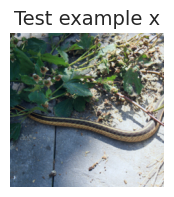

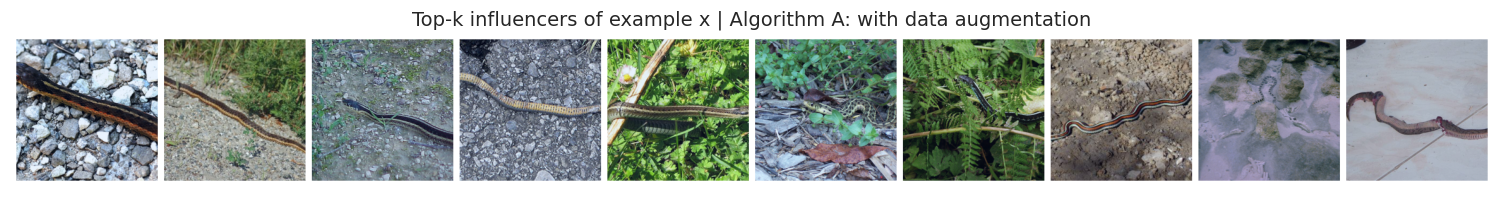

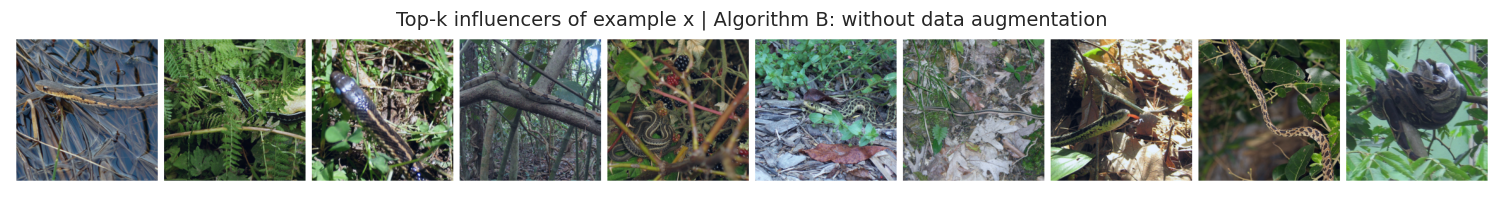

In [135]:
# visualize trak scores of a random example
def get_top_influencers(scores, index, num_infl):
    infl = torch.Tensor(scores[index]).topk(num_infl, largest=True).indices.numpy()
    images = [dsets['train'][i][0] for i in infl]
    return torch.stack(images)

scores_with, scores_without = diff1['scores']['A'], diff1['scores']['B']
random_index = np.random.randint(scores_with.shape[0])

infl_with = get_top_influencers(scores_with, random_index, 10)
infl_without = get_top_influencers(scores_without, random_index, 10)

fig, ax = plot_utils.plot_image_grid(dsets['val'][random_index][0])
plot_utils.update_ax(ax, 'Test example x')

fig, ax = plot_utils.plot_image_grid(infl_with)
plot_utils.update_ax(ax, 'Top-k influencers of example x | Algorithm A: with data augmentation')

fig, ax = plot_utils.plot_image_grid(infl_without)
plot_utils.update_ax(ax, 'Top-k influencers of example x | Algorithm B: without data augmentation')

/tmp/ipykernel_1064664/753807203.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Axes: title={'center': 'Cosine similarity histogram'}>

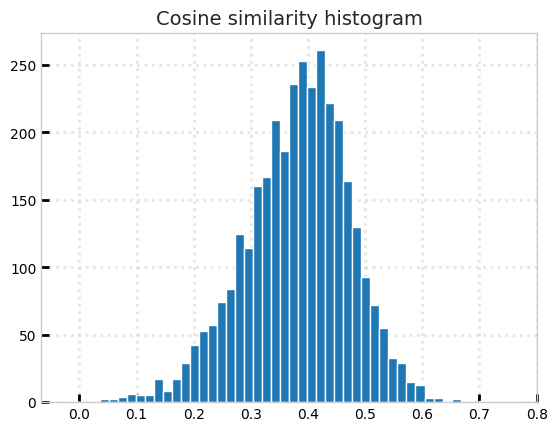

In [136]:
# given example x, compute cosine similarity of its trak scores corresponding to algorithm A and B 
def get_cosine_similarity(dm1, dm2):
    n1 = np.linalg.norm(dm1, axis=1)
    n2 = np.linalg.norm(dm2, axis=1)
    return (dm1*dm2).sum(axis=1)/(n1*n2)

scores_with, scores_without = diff1['scores']['A'], diff1['scores']['B']
cosine_sim = get_cosine_similarity(scores_with, scores_without)

plt.style.use('seaborn-whitegrid')
plt.hist(cosine_sim, bins=50, edgecolor='white')
plot_utils.update_ax(plt.gca(), 'Cosine similarity histogram')

<Axes: title={'center': 'Distinguishing directions'}, xlabel='Explained var. under alg A (with data aug)', ylabel='Explained var. under alg B (without aug)'>

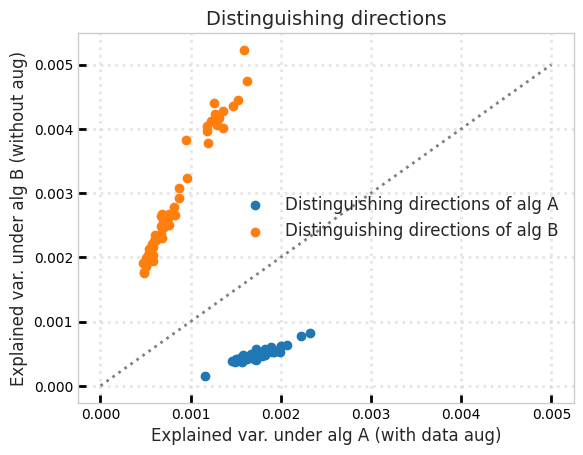

In [137]:
# plot explained variance 
ab_pairs = (diff1['variances']['A'], diff1['variances']['B'])
ba_pairs = (diff2['variances']['B'], diff2['variances']['A'])

plt.scatter(*ab_pairs, label='Distinguishing directions of alg A')
plt.scatter(*ba_pairs, label='Distinguishing directions of alg B')
x = np.linspace(0., 0.005)
plt.plot(x,x, ls=':', lw=2, color='gray')

plot_utils.update_ax(plt.gca(), 
                     'Distinguishing directions',
                     'Explained var. under alg A (with data aug)',
                     'Explained var. under alg B (without aug)',
                     legend_loc='center right', )